In [20]:
import scipy as sp
import collections
from scipy.spatial import distance_matrix
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import shapely.wkt
from shapely.geometry import Point
import json
import sklearn
from sklearn.neighbors import NearestNeighbors
import sklearn.preprocessing as preprocessing
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from convertbng.util import convert_bng, convert_lonlat
from datetime import datetime

# Effective Amenity 
For amenity $i$
$$A_i = \sum_{j=1}^{N_c} \mathrm{e}^{-\gamma d_{ij}} =\sum_{j=1}^{k}\mathrm{e}^{-\gamma d_ij} + \sum_{j=k+1}^{N_c}\mathrm{e}^{-\gamma d_ij} = \sum_{j=1}^{k}\mathrm{e}^{-\gamma d_{ij}}+\epsilon $$


#### about $\gamma$ calibration not clear...
To calibrate $\gamma$, choose $\gamma$ s.t. $\Delta d = \frac{2}{\gamma}$ is the distance that at which contribution of another amenity i to amenity j is halved. Hidalgo chose $\Delta d = 62.5 m $ hence $\gamma = 16$   

$k$ is the nearest k neighbor and Hidalgo chose 2000.


In [71]:
X_toy

array([[-1, -1],
       [-2, -1],
       [-3, -2],
       [ 1,  1],
       [ 2,  1],
       [ 3,  2]])

In [96]:
Hidalgo_Cluster(X_toy,3,0.5,2,-0.5)


A_i_arr is  [1.1765692894986055, 1.264440065654479, 0.9020755853708965, 1.1765692894986055, 1.264440065654479, 0.9020755853708965]


[False, True, False, False, True, False]

In [95]:
def Hidalgo_Cluster(X,n_neighbors,gamma,a,b):
    ### 1. find nearest neighbors
    nbrs = NearestNeighbors(n_neighbors+1, algorithm='auto').fit(X) 
    distances, indices = nbrs.kneighbors(X) 
    ### 2. calculate Ai
    A_i_arr=_effectiveAmenities(gamma,distances,n_neighbors)
    ### 3. id centers based on Ai
    is_cluster_center_arr=_idCenters(A_i_arr,indices,a,b)
    ## plot centers
    ### 4. assign points to centers
    ## 4.1 initialization. plot
    ## 4.2 assign other points too. plot
    return is_cluster_center_arr

In [94]:
def _effectiveAmenities(gamma,distances,n_neighbors):
    """
    -------
    Calculate effective number of amenities for each amenity
    
    Parameters
    -------
    X: matrix (with two columns -- eastings and northings)
    n_neighbors: int (number of neigherbors searched)
    gamma: float (distance decay parameter)
    
    Returns
    -------
    array of floats
    
    Reference
    -------
    [1]Hidalgo, C. A., & Castañer, E. E. (2015). The amenity space and the evolution of neighborhoods. arXiv Preprint arXiv:1509.02868. Retrieved from https://arxiv.org/abs/1509.02868

 
    """
#     ## get indices and distance matrix for each parameter and its k nearest neighbor.
#     # here, feed n_neighbors+1 bc the algorithm includes the node itself
#     nbrs = NearestNeighbors(n_neighbors+1, algorithm='auto').fit(X) 
#     distances, indices = nbrs.kneighbors(X) 
    
    
#     # grope dimension of the indice matrix
    N_c = len(distances) # total number of amenities
# #     k = n_neighbors  # k is number of nearest neighbor examined, should be n_neighbors as well.
   
    # set up storage of computed data
    A_i_arr = [] # declaring an empty array to store effective amenities for each i
    
    # calculate A_i for each i
    for i in range(0,N_c):
        A_i_temp =0
        
        # loop through all k nearest neighbors, index going from 1 to k+1
        for j in range(1,n_neighbors+1):
            
            # contribution each neighbor has to j's effective amenity pairwise
            j_to_i = math.exp(-gamma*distances[i][j])    
            A_i_temp = A_i_temp + j_to_i
            
        A_i_arr.append(A_i_temp)
    print "A_i_arr is ", A_i_arr
    return(A_i_arr)
            


# Definition of cluster centers: 
if amenity i has higher $A_i$ that is higher than its $n_i$ neighbors and somehow, Hidalgo defined $n_i$ as:
$$n_i = 3 A_i + 50 $$

well, for the general form
$$n_i = a A_i + b $$
$a$ bigger -> more likely to identify "centers" in the middle of nowhere

$b$ smaller -> want more centers

but the calibration depends on the scale of the actual data

In [93]:
# def _effectiveAmenities(X,n_neighbors,gamma):

def _idCenters(A_i_arr,indices,a,b):
    """
    -------
    identifying cluster centers
    
    Parameters
    -------
    A_i_arr: array of floats
    indices: matrix of int (k nearest neighbor indices)

    
    Returns
    -------
    array of bools
    
    Reference
    -------
    [1]Hidalgo, C. A., & Castañer, E. E. (2015). The amenity space and the evolution of neighborhoods. arXiv Preprint arXiv:1509.02868. Retrieved from https://arxiv.org/abs/1509.02868

 
    """
   
    
    
    ## get the ni defined above, number of closest neighbors for each i to be examined.
    n_i_arr = np.add(np.multiply(A_i_arr,a),b).astype(int)  

    
    if max(n_i_arr)< len(indices[0]):
    
    
        ## set up storage of binary judgment value
        is_cluster_center_arr = []

        for i in range(0,len(A_i_arr)):

            i_is_cluster_center = True
            ## for amenity i, its n_i closest neighbors are indices[i][1:n_i_arr +1]
            i_ni_nearest_neighbors_indices = indices[i][1:n_i_arr[i] +1] # array of indices of nodes that are i's nearest neighbor
        
            ## if Ai >= all its ni neighbors, then i is a cluster center.
            for j in range(0,len(i_ni_nearest_neighbors_indices)):
                if A_i_arr[i_ni_nearest_neighbors_indices[j]] > A_i_arr[i]: 
                    i_is_cluster_center = False

            is_cluster_center_arr.append(i_is_cluster_center)
            
        return(is_cluster_center_arr)
    else:
        print(n_i_arr)
        print "Please change parameter. A_i is too large."
        return






# ------------------------------------
# I. Data Preparation
### (a) read csv.

In [5]:
df = pd.read_csv("/Users/June/urbanDNA/data/final_amenities.csv")

df.head()

,id,lat,lon,amenity,type,points
0,108042,51.523544,-0.135599,pub,Food and Drinks,POINT(-0.1355991 51.5235442)
1,108539,51.529125,-0.093388,bicycle rental,Services,POINT(-0.09338780000000001 51.5291251)
2,283885,51.494987,0.015537,park,Other,POINT(0.0155375 51.4949874)
3,451152,51.600840,-0.194608,pub,Food and Drinks,POINT(-0.1946078 51.6008404)
4,451153,51.602031,-0.193503,restaurant,Food and Drinks,POINT(-0.1935029 51.6020306)


### (b) df --> gdf  
for plotting for example

In [6]:
# ### First, from geopandas import GeoDataFrame, and viz
# dff = df
# geometry = [Point(xy) for xy in zip(dff.lon, dff.lat)]
# dff = dff.drop(['lon', 'lat'], axis=1)
# crs = {'init': 'WGS84'} ## double check if the json is in WGS84
# geo_dff = gpd.GeoDataFrame(dff, crs=crs, geometry=geometry)
# geo_dff

### (c) re-project into BNG 
in order to calculate distance

In [ ]:
n_e_list = convert_bng(df['lon'], df['lat'])
df_BNG = df.drop(['lon', 'lat',"points","type"], axis=1)
df_BNG['est'] = n_e_list[0]
df_BNG['nor']= n_e_list[1]
df_BNG.head() ### bng, pd.DataFrame


### (d) df_BNG -> geo_df_BNG

In [8]:
# dff_BNG = df_BNG
# geometry = [Point(xy) for xy in zip(dff_BNG.nor, dff_BNG.est)]
# dff_BNG = dff_BNG.drop(['nor', 'est'], axis=1)
# crs = {'init': 'OSGB36'} 
# geo_df_BNG = gpd.GeoDataFrame(dff_BNG, crs=crs, geometry=geometry)
# geo_df_BNG ### bng, gpd.GeoDataFrame

# II. Clusterring
## A. Effective number of amenities
### (a) Finding k nearest neighbors [... now incorporated into effective amenities function]

In [9]:
# ##################### ALWAYS DOUBLE CHECK THE COLUMNS ##########################
# X=df_BNG.as_matrix(columns=df_BNG.columns[2:4])
# nbrs = NearestNeighbors(n_neighbors+1, algorithm='auto').fit(X) 
# distances, indices = nbrs.kneighbors(X) 

# # indices and distances are matrices / nested arrays ## actually scratch paper material
# indices
# indices[0][1:4]


# indices_df =pd.DataFrame(indices)
# indices_df.head()

### (b) Find effective amenities $A_i$ for each amenity

In [19]:
np.log(2)/16

0.04332169878499658

In [13]:
# Do not run unless you have time...
X=df_BNG.as_matrix(columns=df_BNG.columns[2:4])

A_i_arr = effectiveAmenities(X,2000,0.005)

### Calibration for gamma -- 
# hidalgo -- gamma =16
# 16 * 0.500 / (1.33 * 60) = 0.010
# hence, 0.01 

A_i_arr_view = np.around(A_i_arr,2)

df_BNG['Ai']=A_i_arr_view

# df_BNG['Ai_log']=np.log10(A_i_arr)
# df_BNG = df_BNG.drop(['Ai_log'], axis=1)
df_BNG.head()
# help(math.log)


KeyboardInterrupt: 

### (c) Mapping $A_i$
always viz to check if the result makes sense, right?

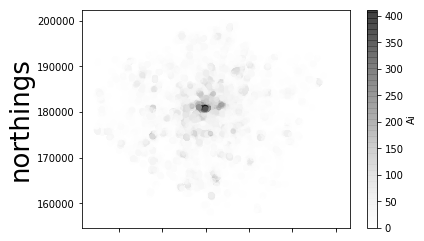

In [40]:
df_BNG.plot.scatter(x='est', y='nor',c='Ai',cmap='', alpha=0.5) 
plt.title('Affective Amenities', fontsize=30)
plt.ylabel('northings', fontsize=15)
plt.xlabel('eastings', fontsize=15)
plt.show()

## B. Identifying cluster centers

In [41]:
results =idClusterCenters(A_i_arr,indices)

[465 226  72 ..., 934 967 510]


In [42]:
df_BNG['centers']=results
df_BNG.head()
df_BNG[df_BNG['centers']].head()
# print(df["Ai"].max())


,id,amenity,est,nor,Ai,centers
1781,23031361,parking,516253.131,175766.890,8.78,True
4183,33077543,pub,513580.818,175584.258,10.40,True
5105,41599360,parking,535636.825,179062.663,36.67,True
5419,44806942,parking,547077.957,168107.961,6.36,True
5462,45292830,fast food,554814.665,190668.576,12.16,True


In [43]:
pd.Series.value_counts(df_BNG['centers'])

False    63643
True       190
Name: centers, dtype: int64

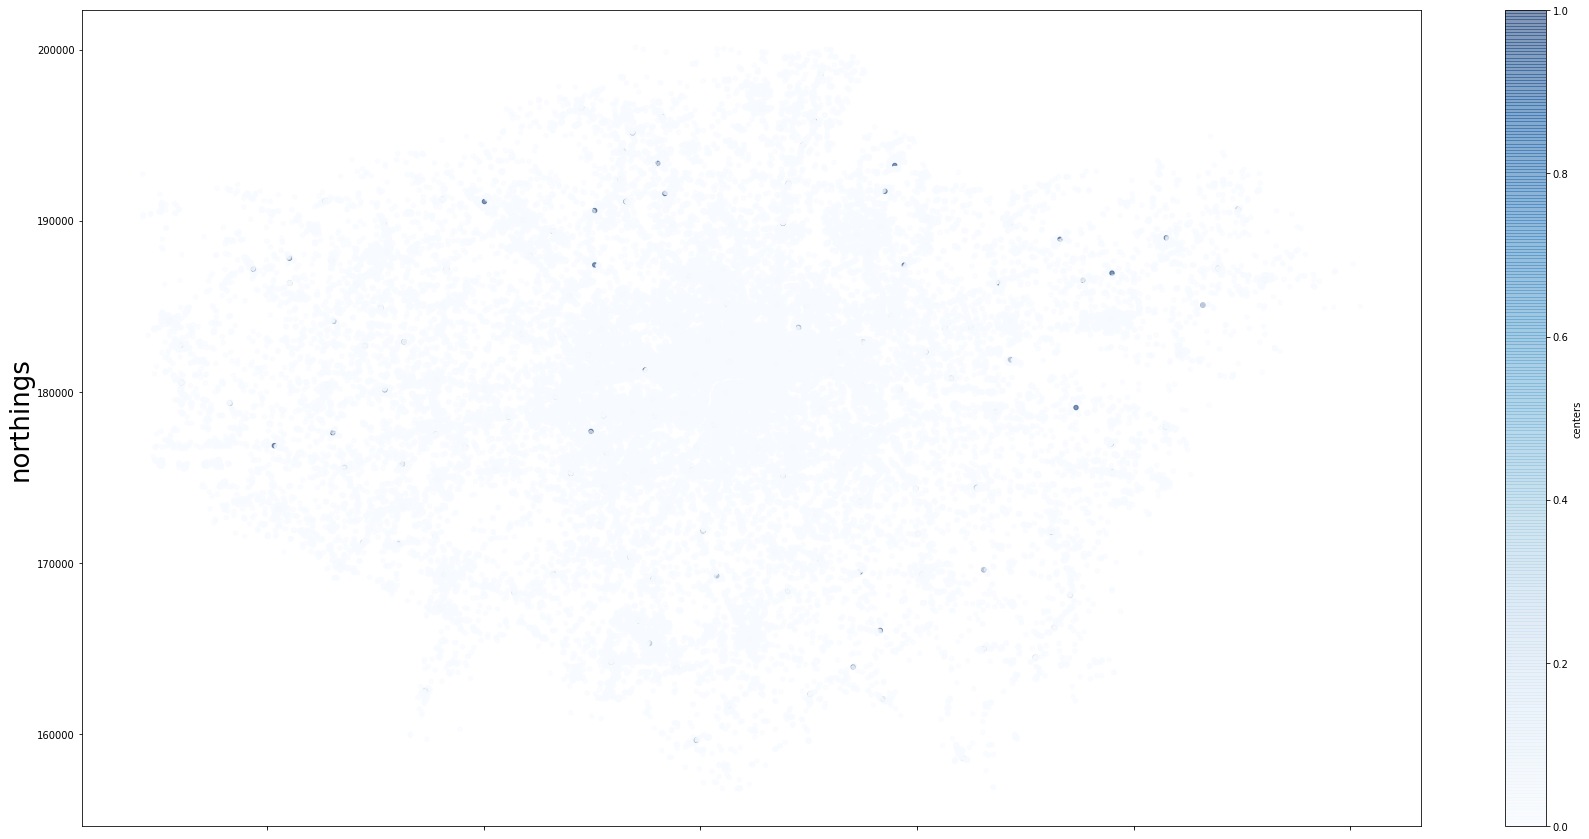

In [44]:
df_BNG.plot.scatter(x='est', y='nor',c='centers',figsize=(30,15),cmap='Blues', alpha=0.5) 
#plt.title('OSM amenities plot', fontsize=30)
plt.xlabel('eastings', fontsize=26)
plt.ylabel('northings', fontsize=26)
plt.show()

## C. Assigning points to clusters
### (a) remove 10% of points with lowest $A_i$

In [45]:
threshold_10 = np.percentile(df_BNG['Ai'], 20) # threshold of the lowest 10%
df_BNG_90=df_BNG[df_BNG['Ai']> threshold_10]
pd.Series.value_counts(df_BNG_90['centers']) # check if centers were removed as outlier, not that it matters...

False    50896
True       165
Name: centers, dtype: int64

### (b) set up data structure for clustering

In [46]:
# set up label column to show what cluster each point belongs to. -2 means unassigned yet.
# didn't use -1 because -1 is by convention the outlier label 

df_BNG_90['label'] = np.full((len(df_BNG_90),1),-2) 
df_BNG_90.head()



/Users/June/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,id,amenity,est,nor,Ai,centers,label
0,108042,pub,529440.033,182161.332,138.55,False,-2
1,108539,bicycle rental,532352.034,182857.383,58.74,False,-2
3,451152,pub,525134.348,190654.281,18.55,False,-2
4,451153,restaurant,525207.595,190788.528,15.46,False,-2
5,451154,pub,525041.014,190512.428,18.89,False,-2


In [47]:
### get centers' information
centers_df = df_BNG_90[df_BNG_90.centers == True]
num_clusters = len(centers_df)
center_index_arr = df_BNG_90.index[df_BNG_90.centers == True].values

## get border points' (non-centers) information
border_points_df=df_BNG_90[df_BNG_90.label == -2]
border_points_index_arr = df_BNG_90.index[df_BNG_90.centers==False].values

### fill the cluster centers' labels
for i in range(0,num_clusters):
    df_BNG_90.set_value(center_index_arr[i],'label',i)
    
centers_df.head()


,id,amenity,est,nor,Ai,centers,label
5105,41599360,parking,535636.825,179062.663,36.67,True,-2
5462,45292830,fast food,554814.665,190668.576,12.16,True,-2
6346,59418836,hairdresser,513384.983,169865.504,32.87,True,-2
7514,78230924,hairdresser,534262.929,176749.155,77.36,True,-2
7999,85658372,cafe,532656.016,176713.014,52.79,True,-2


### (b) initialize by assigning points within "0.5 km" radius of the identified center to the clusters.

In [48]:
initialization = df_BNG_90.copy()
r = 800
for i in range(0,len(center_index_arr)):
    
    for j in range (0,len(border_points_index_arr)):
        dx = centers_df.loc[center_index_arr[i],"est"] - border_points_df.loc[border_points_index_arr[j],"est"]
        dy = centers_df.loc[center_index_arr[i],"nor"] - border_points_df.loc[border_points_index_arr[j],"nor"]
        
        if math.hypot(dx, dy)<r:
            initialization.set_value(border_points_index_arr[j],'label',i)
    

In [49]:
pd.Series.value_counts(initialization['label']) 
# To see distribution of assiging. most are not assigned. 
# to speed up the process, can enlarge radius.


-2      16556
 13      2857
 52      1464
 94      1043
 133      877
 121      727
 82       725
 43       697
 24       629
 98       625
 54       574
 72       537
 30       533
 136      487
 107      458
 151      429
 17       417
 37       414
 50       405
 161      399
 56       391
 74       391
 6        386
 144      385
 48       358
 103      329
 162      329
 61       322
 141      316
 93       313
        ...  
 89        45
 45        45
 20        45
 57        44
 164       42
 139       40
 118       40
 112       40
 73        39
 71        35
 108       33
 10        28
 105       27
 145       26
 100       26
 63        23
 47        21
 114       18
 83        18
 85        17
 38        17
 111       17
 137       16
 49        16
 147       15
 95        13
 68        12
 19        11
 1          9
 106        7
Name: label, Length: 166, dtype: int64

In [50]:
initialization.to_csv("initialization_r800_gm5.csv")

### (c) Viz result of initialization

NB.color for -2 is the unassigned ones

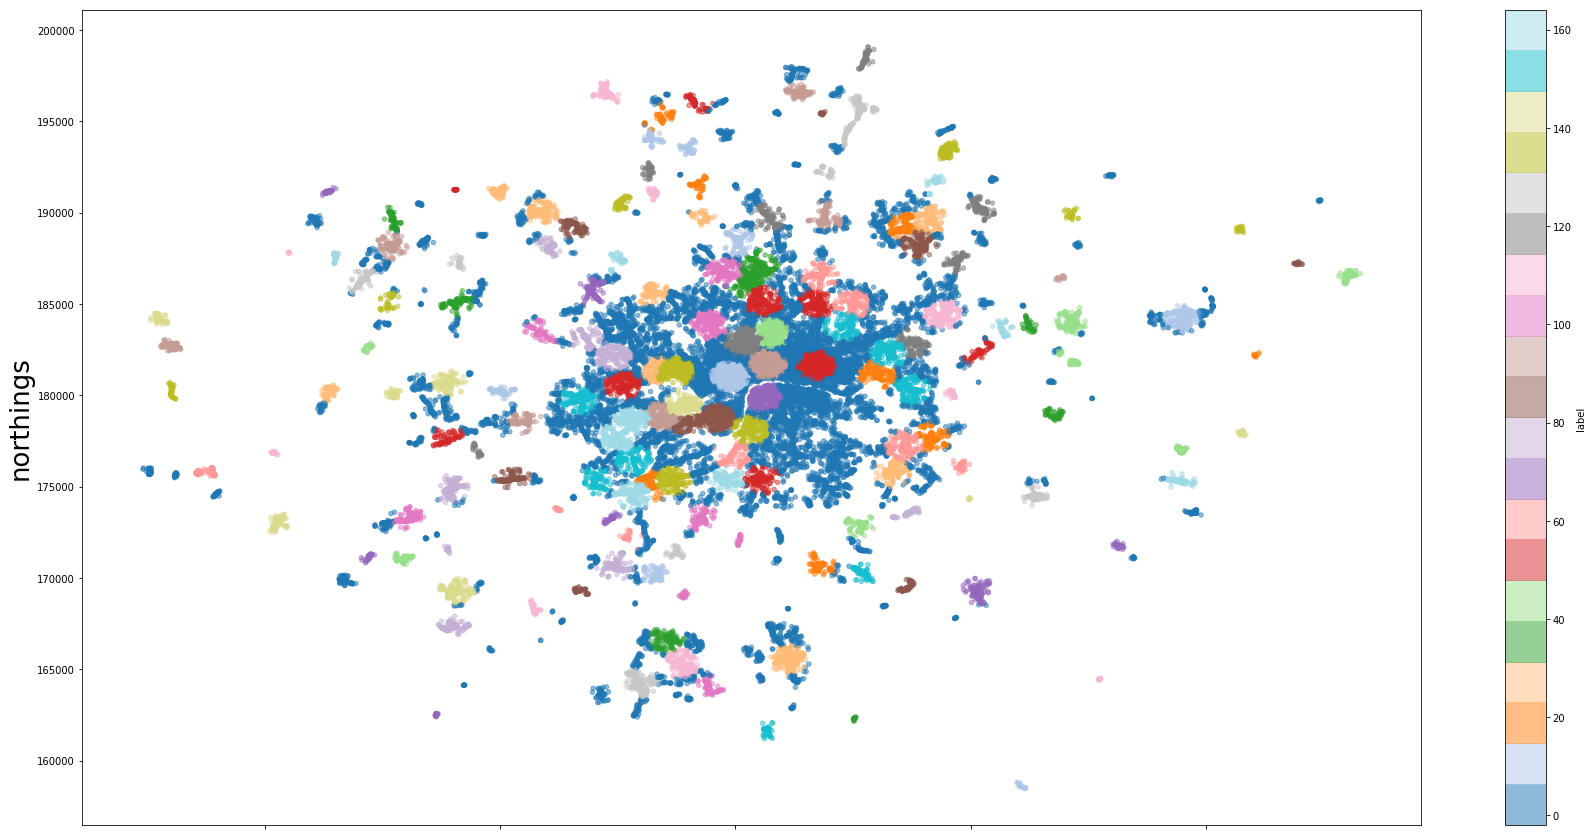

In [51]:
initialization.plot.scatter(x='est', y='nor',c='label',figsize=(30,15),cmap='tab20', alpha=0.5) 
#plt.title('OSM amenities plot', fontsize=30)
plt.ylabel('northings', fontsize=26)
plt.xlabel('eastings', fontsize=26)
plt.show()

### (d) assign rest of the points [test run -- just one iteration. it works.]

In [52]:
### trying to get smarter
def assignPoints (input_df):
    
    
    unassigned_points = input_df[input_df.label == -2]
    unassigned_points_coords = unassigned_points.drop(['id','amenity','Ai','centers','label'],axis=1)
    unassigned_points_coords = pd.DataFrame.as_matrix(unassigned_points_coords)

    assigned_points = input_df[input_df.label != -2]
    assigned_points_coords = assigned_points.drop(['id','amenity','Ai','centers','label'],axis=1)
    assigned_points_coords = pd.DataFrame.as_matrix(assigned_points_coords)

    distmatrix = distance_matrix(assigned_points_coords,unassigned_points_coords)
    distmatrix_df = pd.DataFrame(distmatrix)

    num_rows =len(distmatrix)
    min_dists =  [99999] * len(unassigned_points)



    for i in range(0,num_rows):
        a_0=np.argmin(distmatrix[i,:])  # a_0 because it's first stage of getting value a
#         cols_for_min_2[i]=a_0
        

        if distmatrix[i,a_0] < min_dists[a_0]:
# 

            min_dists[a_0] = distmatrix[i,a_0]
            input_df.set_value(unassigned_points.iloc[[a_0]].index.values,'label',assigned_points.iloc[[i]].label.values) 
            
    print(collections.Counter(input_df.label)) # after assignment (assign popular ones to the last occurrence)
    

In [53]:
one_run = initialization.copy()

In [54]:
start=datetime.now()



assignPoints(one_run)
    

print datetime.now()-start

Counter({-2: 15114, 13: 2946, 52: 1526, 94: 1103, 133: 902, 121: 760, 82: 744, 43: 721, 24: 647, 98: 646, 54: 602, 72: 566, 30: 546, 136: 500, 107: 483, 151: 451, 17: 430, 50: 426, 37: 423, 161: 417, 56: 414, 6: 411, 74: 394, 144: 394, 48: 374, 103: 355, 162: 342, 61: 334, 77: 334, 93: 327, 141: 324, 158: 320, 152: 317, 58: 316, 132: 314, 75: 302, 84: 300, 3: 293, 28: 291, 130: 289, 34: 279, 149: 276, 160: 272, 4: 261, 36: 261, 67: 255, 81: 252, 8: 250, 91: 250, 153: 249, 16: 242, 44: 240, 29: 233, 5: 230, 25: 230, 65: 229, 154: 225, 150: 223, 60: 222, 97: 220, 21: 218, 116: 218, 88: 212, 11: 209, 117: 205, 104: 198, 143: 194, 79: 186, 110: 186, 92: 179, 22: 176, 101: 171, 46: 168, 18: 166, 129: 166, 27: 162, 119: 161, 128: 161, 40: 160, 80: 158, 96: 158, 62: 153, 39: 152, 155: 150, 157: 138, 35: 129, 120: 128, 51: 126, 42: 125, 124: 125, 0: 123, 64: 122, 109: 122, 122: 120, 99: 116, 148: 112, 146: 109, 87: 104, 134: 103, 126: 101, 53: 92, 31: 89, 78: 88, 159: 88, 86: 87, 102: 87, 138:

###  This is the iteration while loop

In [55]:
count = 1
start=datetime.now()

while collections.Counter(one_run.label)[-2]>0:
    assignPoints(one_run)
    count = count + 1
    print('This is iteration number: '+ str(count))
    
print datetime.now()-start

Counter({-2: 13654, 13: 3028, 52: 1590, 94: 1150, 133: 931, 121: 784, 82: 757, 43: 746, 98: 671, 24: 662, 54: 633, 72: 598, 30: 556, 136: 521, 107: 505, 151: 477, 17: 445, 50: 445, 56: 438, 6: 437, 161: 433, 37: 429, 144: 405, 74: 397, 48: 393, 103: 377, 77: 360, 162: 352, 61: 346, 158: 345, 152: 342, 93: 340, 132: 336, 141: 333, 58: 331, 75: 314, 3: 309, 84: 309, 28: 300, 130: 299, 149: 295, 34: 286, 160: 283, 4: 278, 36: 269, 153: 266, 8: 260, 91: 260, 67: 256, 81: 255, 16: 253, 29: 251, 5: 246, 25: 245, 44: 242, 65: 241, 60: 238, 150: 238, 154: 237, 97: 232, 116: 223, 21: 221, 88: 218, 11: 215, 117: 214, 104: 205, 79: 200, 110: 199, 143: 197, 92: 192, 22: 189, 101: 179, 119: 175, 129: 175, 27: 172, 18: 169, 39: 169, 46: 168, 128: 165, 40: 164, 62: 163, 96: 162, 80: 161, 155: 155, 157: 140, 0: 136, 35: 132, 120: 132, 51: 128, 124: 127, 64: 126, 42: 125, 109: 124, 99: 121, 122: 121, 148: 114, 146: 111, 126: 108, 134: 108, 87: 106, 53: 101, 78: 94, 102: 94, 138: 91, 159: 91, 31: 90, 86

Counter({-2: 5567, 13: 3435, 52: 2011, 94: 1355, 133: 1150, 121: 917, 43: 914, 98: 844, 82: 824, 24: 794, 54: 794, 72: 788, 151: 672, 136: 669, 107: 627, 30: 610, 6: 604, 56: 568, 17: 544, 50: 525, 158: 513, 161: 511, 48: 492, 37: 490, 77: 476, 144: 473, 103: 465, 132: 448, 152: 420, 61: 406, 74: 405, 150: 400, 153: 396, 141: 393, 3: 392, 58: 383, 25: 382, 93: 381, 149: 371, 130: 366, 160: 366, 162: 365, 4: 347, 29: 345, 75: 340, 34: 337, 84: 336, 36: 330, 60: 330, 91: 322, 28: 321, 16: 319, 5: 306, 8: 297, 65: 297, 81: 290, 97: 282, 117: 277, 154: 271, 22: 269, 11: 261, 67: 259, 79: 259, 44: 256, 110: 253, 116: 248, 39: 244, 21: 242, 88: 236, 104: 229, 92: 228, 119: 228, 62: 226, 101: 226, 96: 216, 0: 213, 143: 205, 27: 193, 129: 193, 40: 192, 128: 191, 155: 188, 120: 178, 46: 174, 18: 173, 126: 169, 80: 168, 157: 165, 53: 151, 64: 150, 146: 148, 35: 144, 51: 141, 124: 136, 99: 134, 134: 131, 109: 129, 42: 125, 122: 124, 148: 122, 138: 121, 102: 119, 59: 118, 159: 113, 87: 108, 57: 10

Counter({13: 3638, 52: 2461, -2: 1534, 94: 1423, 133: 1377, 98: 1021, 43: 995, 121: 992, 72: 941, 24: 885, 82: 825, 54: 801, 151: 745, 136: 744, 107: 686, 6: 678, 17: 627, 30: 624, 56: 602, 50: 576, 161: 539, 158: 530, 37: 523, 144: 523, 103: 519, 48: 510, 132: 508, 150: 502, 77: 488, 25: 472, 153: 438, 141: 431, 3: 430, 152: 425, 130: 423, 160: 421, 149: 418, 61: 416, 74: 409, 4: 399, 22: 393, 93: 389, 58: 383, 29: 375, 34: 368, 162: 365, 36: 363, 75: 357, 16: 355, 84: 350, 60: 348, 81: 338, 91: 332, 5: 327, 28: 322, 11: 319, 117: 310, 65: 304, 8: 302, 0: 286, 97: 282, 154: 274, 79: 269, 110: 265, 44: 261, 21: 260, 67: 259, 116: 255, 92: 254, 39: 249, 88: 249, 119: 249, 62: 246, 96: 242, 104: 235, 101: 233, 143: 205, 40: 196, 27: 193, 128: 193, 129: 193, 155: 193, 120: 189, 157: 189, 53: 185, 126: 183, 46: 179, 18: 173, 80: 170, 64: 156, 51: 154, 146: 152, 35: 145, 99: 142, 124: 136, 134: 136, 102: 134, 148: 132, 109: 129, 42: 125, 122: 125, 59: 122, 138: 121, 159: 116, 105: 115, 78: 

Counter({13: 3769, 52: 2677, 94: 1454, 133: 1451, 98: 1115, 72: 1075, 121: 1041, 43: 1031, 24: 907, 82: 825, 54: 801, 136: 747, 151: 745, 107: 688, 6: 682, 17: 628, 30: 624, 56: 604, 50: 589, 161: 539, 144: 533, 158: 530, 132: 526, 103: 525, 37: 523, 150: 517, 48: 510, 77: 488, 25: 478, 130: 463, 3: 460, 153: 438, 141: 437, 152: 425, 160: 421, 149: 419, 4: 417, 61: 416, 74: 409, 22: 401, 93: 389, 58: 383, 34: 382, 29: 375, 162: 365, 36: 363, -2: 363, 75: 357, 16: 355, 0: 353, 60: 350, 84: 350, 81: 344, 5: 335, 91: 332, 28: 322, 11: 319, 117: 310, 65: 304, 8: 302, 97: 282, 154: 274, 21: 269, 79: 269, 110: 269, 44: 263, 67: 259, 116: 255, 119: 255, 92: 254, 39: 249, 88: 249, 62: 246, 96: 245, 104: 235, 101: 233, 143: 205, 155: 198, 40: 196, 27: 193, 128: 193, 129: 193, 53: 191, 120: 189, 157: 189, 126: 183, 46: 179, 18: 173, 80: 170, 51: 159, 64: 156, 146: 152, 35: 145, 102: 145, 99: 142, 124: 136, 134: 136, 148: 132, 109: 129, 42: 125, 122: 125, 59: 122, 138: 121, 105: 120, 159: 116, 78

Counter({13: 3795, 52: 2755, 133: 1469, 94: 1458, 72: 1162, 98: 1129, 121: 1051, 43: 1033, 24: 907, 82: 825, 54: 801, 136: 747, 151: 745, 107: 688, 6: 682, 17: 628, 30: 624, 56: 604, 50: 589, 161: 539, 144: 533, 158: 530, 132: 526, 103: 525, 37: 523, 150: 517, 48: 510, 3: 500, 77: 488, 25: 478, 130: 463, 153: 438, 141: 437, 152: 425, 160: 421, 149: 419, 4: 418, 61: 416, 74: 409, 22: 401, 93: 389, 0: 385, 58: 383, 34: 382, 29: 375, 162: 365, 36: 363, 75: 357, 16: 355, 60: 350, 84: 350, 81: 344, 5: 335, 91: 332, 28: 322, 11: 319, 117: 310, 65: 304, 8: 302, 97: 282, 154: 274, 21: 269, 79: 269, 110: 269, 44: 263, 67: 259, 116: 255, 119: 255, 92: 254, 39: 249, 88: 249, 62: 246, 96: 245, 104: 235, 101: 233, 143: 205, 155: 198, 40: 196, 27: 193, 128: 193, 129: 193, 53: 191, 120: 189, 157: 189, 126: 183, 46: 179, 18: 173, 80: 170, 51: 159, 64: 156, 146: 152, 35: 145, 102: 145, 99: 142, 124: 136, 134: 136, 148: 132, 109: 129, 42: 125, 122: 125, 59: 122, 138: 121, 105: 120, 159: 116, 78: 113, 31

In [57]:
one_run.to_csv("result.csv")

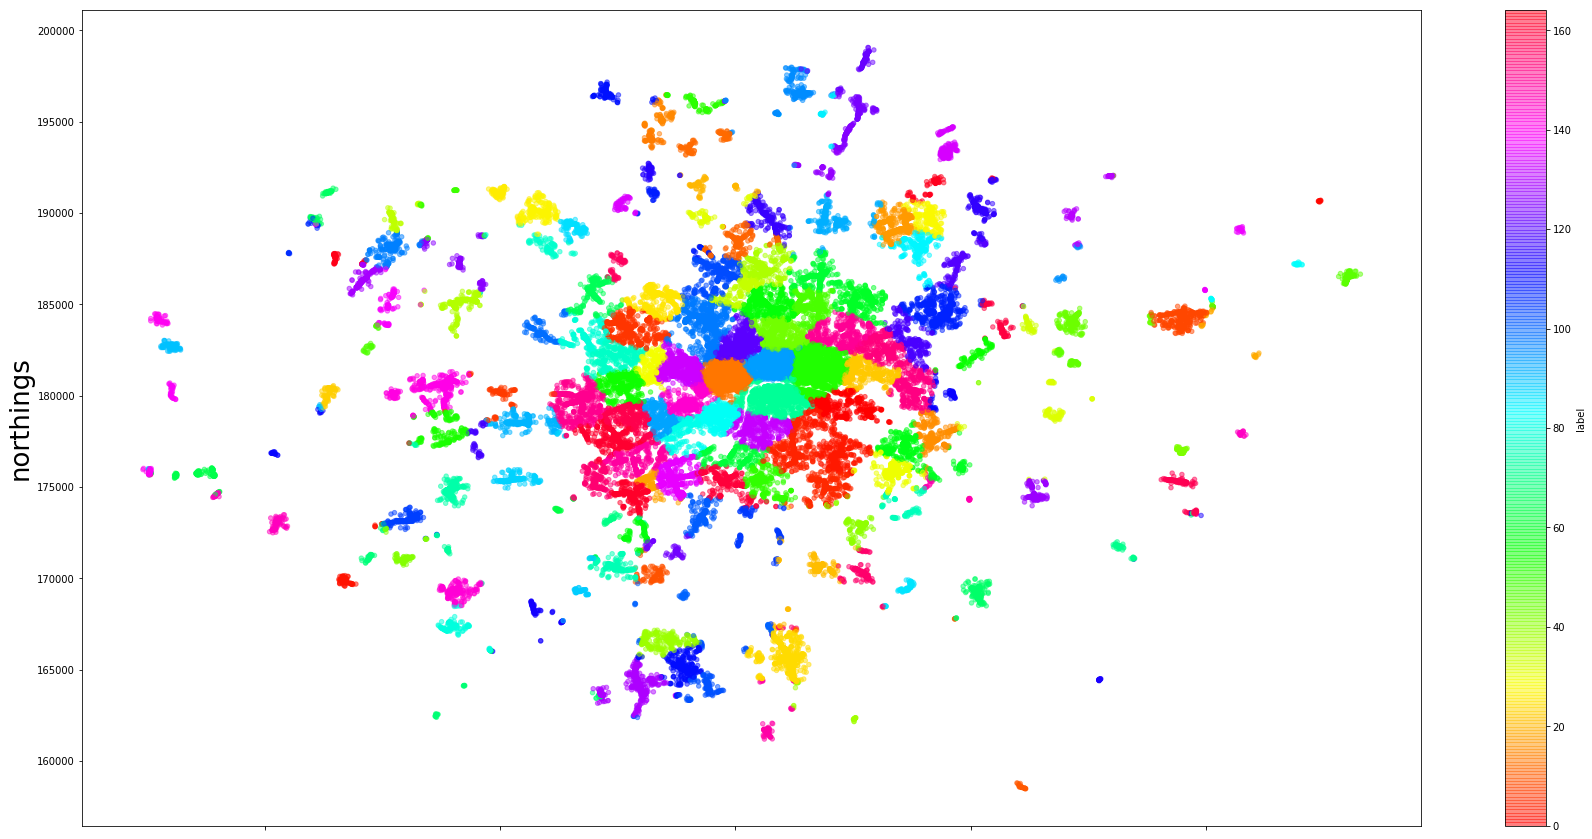

In [59]:
one_run.plot.scatter(x='est', y='nor',c='label',figsize=(30,15),cmap='hsv', alpha=0.5) 
#plt.title('OSM amenities plot', fontsize=30)
plt.ylabel('northings', fontsize=26)
plt.xlabel('eastings', fontsize=26)
plt.show()

In [68]:
r10idlabel=one_run.copy()
r10idlabel=r10idlabel.drop(['amenity','est','nor','Ai','centers'],axis=1)
r10idlabel.head()
# r10idlabel=r10idlabel.drop(['Unnamed: 0'],axis=1)
#df_BNG = df.drop(['lon', 'lat',"points","type"], axis=1)
# r10idlabel.to_csv("ForPolygon.csv")
# r10idlabel.columns = ['origIndex', 'id','label']
# r10idlabel.head()
fullIndex =range(0,63833)
fullIndex =pd.DataFrame(fullIndex,columns=['Indices'])
fullIndex['label']=[-1]*63833
# fullIndex.head()
# OrigIndex = r10idlabel['origIndex']
# OrigIndex = OrigIndex.values
# len(OrigIndex)
# fullIndex['label'].value_counts()

# ##################################################################################################
# ##################################################################################################
# ##################################################################################################
# # assigned_points.iloc[[i]].label.values
# i = 0
# for x in OrigIndex:
#     fullIndex.set_value(x,'label',r10idlabel.iloc[[i]].label.values)
#     i =i+1
    
# fullIndex


# -------------------- Scratch Paper -----------------------

## Toy model for Nearest Neighbors

In [57]:
X_toy = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
# nbrs_toy = NearestNeighbors(n_neighbors=4, algorithm='auto').fit(X_toy)
# distances, indices = nbrs_toy.kneighbors(X_toy)
# len(indices[0])

In [77]:
Hidalgo_Cluster(X_toy,2,0.02,1,1)

[False]

In [30]:
_effectiveAmenities(X_toy,1,0.02)

SyntaxError: non-keyword arg after keyword arg (<ipython-input-30-ab1f3826c03d>, line 1)

In [96]:
distances_toy, indices_toy = nbrs_toy.kneighbors(X_toy)
indices_toy

array([[0, 1, 2, 3],
       [1, 0, 2, 3],
       [2, 1, 0, 3],
       [3, 4, 5, 0],
       [4, 3, 5, 0],
       [5, 4, 3, 0]])

In [71]:
distances_toy # hence, first in the array above is the index compared against. the others are its closest neighbors' indices

array([[ 0.        ,  1.        ,  2.23606798,  2.82842712],
       [ 0.        ,  1.        ,  1.41421356,  3.60555128],
       [ 0.        ,  1.41421356,  2.23606798,  5.        ],
       [ 0.        ,  1.        ,  2.23606798,  2.82842712],
       [ 0.        ,  1.        ,  1.41421356,  3.60555128],
       [ 0.        ,  1.41421356,  2.23606798,  5.        ]])

In [98]:
len(indices_toy) # number of amenities in total. Nc

6

In [99]:
len(indices_toy[0]) # returns k+1 where k is the number of nearest neighbor examined

4

In [124]:
indices_toy[2][1]
distances_toy[len(indices_toy)-1][len(indices_toy[0])-1] 

5.0

These are to test if the function works properly on the toy model

In [117]:
N_c = len(indices_toy) # total number of amenities
k = len(indices_toy[0])-1  # k is number of nearest neighbor examined.
print(N_c)
print(k)

6
3


In [125]:
# set up storage of computed data
A_i_arr = [] # declaring an empty array to store effective amenities for each i
gamma =0.02
# calculate A_i for each i
for i in range(0,N_c):
    A_i_temp =0

# loop through all k nearest neighbors 
    for j in range(1,k+1):

# contribution each neighbor has to j's effective amenity pairwise
        j_to_i = math.exp(-gamma*distances_toy[i][j])    
        A_i_temp = A_i_temp + j_to_i

    A_i_arr.append(A_i_temp)
    
A_i_arr            

[1.1765692894986055,
 1.264440065654479,
 0.9020755853708965,
 1.1765692894986055,
 1.264440065654479,
 0.9020755853708965]

In [158]:
A_i_arr_toy=effectiveAmenities(indices_toy,distances_toy,0.5)
A_i_arr_toy

[1.1765692894986055,
 1.264440065654479,
 0.9020755853708965,
 1.1765692894986055,
 1.264440065654479,
 0.9020755853708965]

In [131]:
round(1.8888, 2)

1.89

In [147]:
np.add(1.88,2)

3.8799999999999999

In [183]:
idClusterCenters(A_i_arr_toy)

[False, True, False, False, True, False]

In [177]:

# get the ni defined above
n_i_arr_toy= np.add(np.multiply(A_i_arr_toy,3),50).astype(int) 
print(n_i_arr_toy)
print((A_i_arr_toy))

# set up storage of binary judgment value
# is_cluster_center_arr = []

# for i in range(0,len(A_i_arr_toy)):

#     i_is_cluster_center = True

#     for j in range(0,len(n_i_arr_toy)):
#         if A_i_arr_toy[j] > A_i_arr_toy[i]:
#           # i_is_cluster_center = False
#             print("is not")

#     is_cluster_center_arr.append(i_is_cluster_center)
   

[53 53 52 53 53 52]
[1.1765692894986055, 1.264440065654479, 0.9020755853708965, 1.1765692894986055, 1.264440065654479, 0.9020755853708965]


In [165]:
is_cluster_center_arr

[False, False, False, False, False, False]

In [1022]:
distance_matrix([[0,0],[0,1],[1,1]], [[1,0],[1,1]]) #the first entry is column. second entry is rows

array([[ 1.        ,  1.41421356],
       [ 1.41421356,  1.        ],
       [ 1.        ,  0.        ]])

In [1136]:
### analogy to regular panda. basic stuff....

s = pd.DataFrame(np.random.randn(8, 4), columns=['A', 'B', 'C', 'D'])
s.A[2] ### dataframe.columnName[rowNumber]
s.iloc[1] = dict(A=1,B=2,C=1,D=0)
s=s.drop(["A","B"],axis=1)
# a1 = pd.DataFrame.as_matrix(s.iloc[[0]])[0]
a1= np.asarray(s.iloc[[0]])[0]
a2 = pd.DataFrame.as_matrix(s.iloc[[1]])[0]
a3 =pd.DataFrame.as_matrix(s.iloc[[2]])[0]
a4 = pd.DataFrame.as_matrix(s.iloc[[3]])[0]
dtest = distance_matrix([a1,a2,a3,a4], [a2,a4])

# a1= np.asarray(s.iloc[[0]])


In [1145]:
dtest

array([[ 0.94442848,  1.33167362],
       [ 0.        ,  2.25099916],
       [ 0.90685934,  1.35244155],
       [ 2.25099916,  0.        ]])

In [1152]:
dtest[0] # gives row zero
dtest[0,:] # gives row zero

dtest[:,1] # gives column one

max(dtest[0,:])
len(dtest)  # number of rows!

4

In [1160]:
np.argmax(dtest[3,:])

0

In [1153]:
# vision. a is index (in initialization) of unassigned 
cols_for_max = [] # column numbers of max in each row, in distance matrix
for i in range(0,len(dtest)):
    a_0=np.argmax(dtest[i,:])  # a_0 because it's first stage of getting value a
    cols_for_max.append(a_0)
    
cols_for_max

[1, 1, 1, 0]

In [1162]:
# np.argmax(distmatrix[0,:])
type(distmatrix)


pandas.core.frame.DataFrame

In [1300]:
### scratch paper
i=0
a_0=np.argmin(distmatrix[i,:])
distmatrix[i,a_0]


2838

### These are testings / processes that lead to the recursive assigning points

In [72]:
### unassigned points
unassigned_points = initialization[initialization.label == -2]
unassigned_points_coords = unassigned_points.drop(['id','amenity','Ai','centers','label'],axis=1)
unassigned_points_coords = pd.DataFrame.as_matrix(unassigned_points_coords)

print(len(unassigned_points_coords)) ## so the length only counts the unassigned ones. the nan doesn't matter.
unassigned_points_coords

4586


array([[ 529440.033,  182161.332],
       [ 528904.893,  182672.735],
       [ 530832.236,  181922.664],
       ..., 
       [ 530173.625,  180659.96 ],
       [ 526654.082,  181570.016],
       [ 532504.222,  179921.796]])

In [73]:
### assigned points
assigned_points = initialization[initialization.label != -2]
assigned_points_coords = assigned_points.drop(['id','amenity','Ai','centers','label'],axis=1)
assigned_points_coords = pd.DataFrame.as_matrix(assigned_points_coords)

print(len(assigned_points_coords)) ## so the length only counts the unassigned ones. the nan doesn't matter.
assigned_points_coords

1399


array([[ 531590.815,  181319.7  ],
       [ 531118.513,  181290.514],
       [ 531638.681,  181470.16 ],
       ..., 
       [ 525879.351,  181188.981],
       [ 530018.168,  180857.576],
       [ 530023.457,  180861.985]])

In [74]:
#### Scratch Paper Stuff ####
# assigned_points['label'].iloc[[0]]
# assigned_points.iloc[[0]].label.values
# assigned_points.iloc[[0]].index
# ## so, within iloc[[SEQUENCE IN NEW DF]] but the index on display / returned by .index are that of  

In [75]:
distmatrix = distance_matrix(assigned_points_coords,unassigned_points_coords)
distmatrix_df = pd.DataFrame(distmatrix)
distmatrix_df # this is for visualization.
#distmatrix

,0,1,2,3,4,5,6,7,8,9,...,4576,4577,4578,4579,4580,4581,4582,4583,4584,4585
0,2309.590361,3007.470815,969.024089,4500.821477,1009.636615,995.350839,1003.354290,363.560943,1165.787410,1944.151936,...,1410.903611,1432.352717,1514.174690,2214.011269,2441.031816,1517.051872,3141.512535,1563.228826,4943.075036,1669.864647
1,1890.930750,2609.721900,693.951110,4028.531555,559.401739,548.546347,537.733750,834.075441,712.779807,2390.899365,...,998.163484,1015.297294,1970.181651,2630.757327,1968.635946,1088.999187,3587.586723,1135.962886,4473.171752,1947.711066
2,2304.728132,2986.600653,924.723422,4551.612746,1043.402138,1026.922969,1051.982485,365.243140,1261.329276,1951.229136,...,1527.269485,1547.153459,1512.890660,2091.432553,2494.804126,1627.485799,3037.979340,1674.160423,4985.599103,1773.863664
3,2351.131517,3048.120269,1006.643145,4542.280055,1051.861552,1037.584495,1045.292555,321.519347,1203.427012,1902.240431,...,1444.157089,1465.974840,1472.012804,2184.599517,2482.445217,1551.620278,3107.141562,1597.655722,4984.904021,1640.784446
4,1906.765932,2608.445764,603.938160,4122.131867,615.314647,599.497413,622.882119,761.656241,870.088751,2347.321118,...,1171.883274,1187.539589,1916.276910,2474.619532,2065.470702,1256.583167,3445.438172,1303.542073,4557.073740,2003.728850
5,2104.460202,2751.027252,691.991316,4449.653716,967.362244,947.377235,1008.761411,675.823759,1316.980874,2207.254953,...,1629.118247,1643.879717,1763.414994,2054.767723,2414.908783,1709.430186,3051.461887,1756.242068,4863.800481,2120.717751
6,3074.882272,3792.954850,2412.649403,4307.804885,2015.134322,2024.359416,1918.587518,2003.417864,1565.222700,2715.110054,...,1326.913587,1348.860632,2501.011094,3892.168680,2573.786194,1415.965388,4634.350134,1415.739056,4814.190929,1549.858931
7,4285.119481,4961.361813,3779.887524,4975.560720,3361.580193,3372.734800,3262.686132,3301.248515,2879.989303,3598.013334,...,2587.741490,2602.757028,3520.039558,5080.133751,3621.447820,2642.933196,5693.112691,2627.500301,5480.120152,2373.679990
8,4149.534676,4883.860006,3236.883752,5481.320019,2944.839295,2948.029323,2860.543786,2372.554394,2588.824786,2301.181899,...,2426.527391,2452.551594,2285.995544,3920.483101,3732.345476,2534.441469,4432.675652,2543.085876,5988.772615,1119.812673
9,1550.233944,2231.535879,1527.230465,2905.887680,1039.370513,1060.005303,960.842327,2107.781939,619.318259,3511.195286,...,412.663737,383.652749,3139.514601,3961.415543,988.072869,282.046411,4915.294292,245.660484,3391.801346,2686.673117


In [82]:
ite_assign = initialization.copy()
# vision. a is index (in initialization) of unassigned. b is index of the assigned. 
cols_for_min = [] # column numbers of min in each row, in distance matrix
for i in range(0,len(distmatrix)):
    a_0=np.argmin(distmatrix[i,:])  # a_0 because it's first stage of getting value a
    cols_for_min.append(a_0) 
    
    a = unassigned_points.iloc[[a_0]].index.values
    b = assigned_points.iloc[[i]].index.values
    b_label = assigned_points.iloc[[i]].label.values
    ite_assign.set_value(a,'label',b_label)   

In [83]:
ite_assign_v2 = initialization.copy()
# vision. a is index (in initialization) of unassigned. b is index of the assigned. 
cols_for_min_2 = np.full((1, len(assigned_points)), 0) # column numbers of max in each row, in distance matrix
cols_for_min_2 = cols_for_min_2[0]
min_dists = np.full((1, len(assigned_points)), 99999999) # a random large value to start with. 
min_dists = min_dists[0]
# min_dists
#cols_for_min_2

for i in range(0,len(distmatrix)):
    a_0=np.argmin(distmatrix[i,:])  # a_0 because it's first stage of getting value a
    cols_for_min_2[i]=a_0
    a = unassigned_points.iloc[[a_0]].index.values
    
    if distmatrix[i,a_0] < min_dists[i]:
        b = assigned_points.iloc[[i]].index.values
        b_label = assigned_points.iloc[[i]].label.values
        
        min_dists[i] = distmatrix[i,a_0]
        ite_assign_v2.set_value(a,'label',b_label)   

In [84]:
# print(collections.Counter(cols_for_min)) # which unassigned points are "popular" (close to many assigned points)
# print(collections.Counter(cols_for_min_2))
print(min_dists)
print(collections.Counter(initialization.label)) # only after initialization, before assign
print(collections.Counter(ite_assign.label)) # after assignment (assign popular ones to the last occurrence)
print(collections.Counter(ite_assign_v2.label)) # after assigining popular ones to the nearest occurence

### but here the results from the last two are the same because all the assigned dots that have the same 

[ 84  53 123 ..., 145 123 117]
Counter({-2: 4586, 2: 369, 9: 293, 3: 164, 6: 133, 8: 117, 1: 114, 0: 61, 7: 50, 4: 49, 5: 49})
Counter({-2: 4463, 2: 393, 9: 316, 3: 181, 6: 143, 8: 132, 1: 126, 0: 68, 4: 57, 7: 56, 5: 50})
Counter({-2: 4463, 2: 393, 9: 316, 3: 181, 6: 143, 8: 132, 1: 126, 0: 68, 4: 57, 7: 56, 5: 50})


In [85]:
#### if we want to see that the second iterative assign is actually doing something. try THIS
ite_asssign_v2 = initialization.copy()
# vision. a is index (in initialization) of unassigned. b is index of the assigned. 
cols_for_min_2 = np.full((1, len(assigned_points)), 0) # column numbers of max in each row, in distance matrix
cols_for_min_2 = cols_for_min_2[0]
min_dists = np.full((1, len(assigned_points)), 100) # try THIS. 100 because it would affect 
min_dists = min_dists[0]
# min_dists
#cols_for_min_2

for i in range(0,len(distmatrix)):
    a_0=np.argmin(distmatrix[i,:])  # a_0 because it's first stage of getting value a
    cols_for_min_2[i]=a_0
    a = unassigned_points.iloc[[a_0]].index.values
    
    if distmatrix[i,a_0] < min_dists[i]:
        b = assigned_points.iloc[[i]].index.values
        b_label = assigned_points.iloc[[i]].label.values
        
        min_dists[i] = distmatrix[i,a_0]
        ite_asssign_v2.set_value(a,'label',b_label)   

In [87]:
# print(collections.Counter(cols_for_min)) # which unassigned points are "popular" (close to many assigned points)
# print(collections.Counter(cols_for_min_2))
print(min_dists)
print(collections.Counter(initialization.label)) # only after initialization, before assign
print(collections.Counter(ite_assign.label)) # after assignment (assign popular ones to the last occurrence)
print(collections.Counter(ite_asssign_v2.label)) # after assigining popular ones to the nearest occurence

### in a way, showing that the if statement is doing something. and very likely the thing i wanted it to do

[ 84  53 100 ..., 100 100 100]
Counter({-2: 4586, 2: 369, 9: 293, 3: 164, 6: 133, 8: 117, 1: 114, 0: 61, 7: 50, 4: 49, 5: 49})
Counter({-2: 4463, 2: 393, 9: 316, 3: 181, 6: 143, 8: 132, 1: 126, 0: 68, 4: 57, 7: 56, 5: 50})
Counter({-2: 4505, 2: 389, 9: 312, 3: 177, 6: 139, 8: 126, 1: 120, 0: 63, 7: 53, 4: 52, 5: 49})


### (e) my way of assiging points

In [1263]:
all_points = initialization.copy()
all_points_coords = all_points.drop(['id','amenity','Ai','centers','label'],axis=1)
all_points_coords = pd.DataFrame.as_matrix(all_points_coords)

5985

In [1265]:
full_d_matrix = distance_matrix(all_points_coords,all_points_coords)

In [1266]:
full_d_matrix_df = pd.DataFrame(full_d_matrix)
full_d_matrix_df # this is for visualization.

,0,1,2,3,4,5,6,7,8,9,...,5975,5976,5977,5978,5979,5980,5981,5982,5983,5984
0,0.000000,740.207976,1412.512516,2500.680277,2309.590361,1890.930750,1336.873747,1345.068557,1385.210325,2304.728132,...,911.656388,1663.972804,5031.994454,1464.972617,1671.010205,3691.059844,2848.012919,1426.190655,1424.319553,3795.362397
1,740.207976,0.000000,2068.153172,2271.673287,3007.470815,2609.721900,2063.877093,2070.362541,2118.358495,2986.600653,...,1397.301678,2377.091692,5546.573660,2175.663463,2379.273857,3369.781940,2506.419628,2129.362210,2128.379897,4530.213531
2,1412.512516,2068.153172,0.000000,3792.616720,969.024089,693.951110,494.243973,474.996337,586.273575,924.723422,...,1794.895926,1382.445632,3685.284823,1304.013239,1424.145302,5006.931253,4193.009833,1340.566730,1333.852845,2607.491119
3,2500.680277,2271.673287,3792.616720,0.000000,4500.821477,4028.531555,3510.174002,3527.635175,3500.802525,4551.612746,...,2059.896357,3182.710174,7477.230365,3036.335838,3150.654523,1216.348453,509.409589,2962.361837,2966.926160,5588.465865
4,2309.590361,3007.470815,969.024089,4500.821477,0.000000,473.202918,1009.636615,995.350839,1003.354290,157.890359,...,2441.031816,1517.051872,3141.512535,1571.150536,1563.228826,5712.959695,4943.075036,1639.139158,1632.823971,1669.864647
5,1890.930750,2609.721900,693.951110,4028.531555,473.202918,0.000000,559.401739,548.546347,537.733750,550.315758,...,1968.635946,1088.999187,3587.586723,1117.560200,1135.962886,5240.145743,4473.171752,1182.452718,1175.918682,1947.711066
6,1336.873747,2063.877093,494.243973,3510.174002,1009.636615,559.401739,0.000000,21.147161,100.147691,1043.402138,...,1458.220935,888.653681,4017.879169,814.081556,930.035871,4725.617893,3942.199961,855.416749,848.594331,2469.622855
7,1345.068557,2070.362541,474.996337,3527.635175,995.350839,548.546347,21.147161,0.000000,115.041064,1026.922969,...,1476.598262,907.544339,3998.155017,834.584555,949.149179,4743.209924,3958.749783,876.241424,869.415083,2464.880203
8,1385.210325,2118.358495,586.273575,3500.802525,1003.354290,537.733750,100.147691,115.041064,0.000000,1051.982485,...,1442.879017,796.949960,4052.469681,734.316893,839.352016,4714.733117,3939.931669,780.423874,773.548257,2411.859304
9,2304.728132,2986.600653,924.723422,4551.612746,157.890359,550.315758,1043.402138,1026.922969,1051.982485,0.000000,...,2494.804126,1627.485799,3037.979340,1666.885111,1674.160423,5766.189702,4985.599103,1732.432261,1725.927403,1773.863664


In [1269]:
assigned_points_index_arr = assigned_points.index.values
assigned_points_index_arr

array([   2,    5,    6, ..., 6646, 6648, 6649])

In [ ]:
J_assign = initialization.copy()
# vision. a is index (in initialization) of unassigned. b is index of the assigned. 
cols_for_max = [] # column numbers of max in each row, in distance matrix
for i in assigned_points_index_arr:
    a=np.argmax(distmatrix[i,:])  # index of the one with shor
    cols_for_max.append(a) 
    
    
    if a not in assigned_points_index_arr:
        
    
    
    a = unassigned_points.iloc[[a_0]].index.values
    b = assigned_points.iloc[[i]].index.values
    b_label = assigned_points.iloc[[i]].label.values
    ite_asssign.set_value(a,'label',b_label)   
    
    
    
    
    assigned_points_index_arr = assigned_points.values

### Iteration testing ... to go one step further ###

In [72]:
### unassigned points
unassigned_points = ite_asssign_v2[ite_asssign_v2.label == -2]
unassigned_points_coords = unassigned_points.drop(['id','amenity','Ai','centers','label'],axis=1)
unassigned_points_coords = pd.DataFrame.as_matrix(unassigned_points_coords)

print(len(unassigned_points_coords)) ## so the length only counts the unassigned ones. the nan doesn't matter.
unassigned_points_coords

4586


array([[ 529440.033,  182161.332],
       [ 528904.893,  182672.735],
       [ 530832.236,  181922.664],
       ..., 
       [ 530173.625,  180659.96 ],
       [ 526654.082,  181570.016],
       [ 532504.222,  179921.796]])

In [89]:
### assigned points
assigned_points = ite_asssign_v2[ite_asssign_v2.label != -2]
assigned_points_coords = assigned_points.drop(['id','amenity','Ai','centers','label'],axis=1)
assigned_points_coords = pd.DataFrame.as_matrix(assigned_points_coords)

print(len(assigned_points_coords)) ## so the length only counts the unassigned ones. the nan doesn't matter.
assigned_points_coords

1480


array([[ 531590.815,  181319.7  ],
       [ 531118.513,  181290.514],
       [ 531638.681,  181470.16 ],
       ..., 
       [ 525879.351,  181188.981],
       [ 530018.168,  180857.576],
       [ 530023.457,  180861.985]])

In [74]:
#### Scratch Paper Stuff ####
# assigned_points['label'].iloc[[0]]
# assigned_points.iloc[[0]].label.values
# assigned_points.iloc[[0]].index
# ## so, within iloc[[SEQUENCE IN NEW DF]] but the index on display / returned by .index are that of  

In [93]:
distmatrix = distance_matrix(assigned_points_coords,unassigned_points_coords)
distmatrix_df = pd.DataFrame(distmatrix)
distmatrix_df.head() # this is for visualization.
#distmatrix

,0,1,2,3,4,5,6,7,8,9,...,4576,4577,4578,4579,4580,4581,4582,4583,4584,4585
0,2309.590361,3007.470815,969.024089,4500.821477,1009.636615,995.350839,1003.354290,363.560943,1165.787410,1944.151936,...,1410.903611,1432.352717,1514.174690,2214.011269,2441.031816,1517.051872,3141.512535,1563.228826,4943.075036,1669.864647
1,1890.930750,2609.721900,693.951110,4028.531555,559.401739,548.546347,537.733750,834.075441,712.779807,2390.899365,...,998.163484,1015.297294,1970.181651,2630.757327,1968.635946,1088.999187,3587.586723,1135.962886,4473.171752,1947.711066
2,2304.728132,2986.600653,924.723422,4551.612746,1043.402138,1026.922969,1051.982485,365.243140,1261.329276,1951.229136,...,1527.269485,1547.153459,1512.890660,2091.432553,2494.804126,1627.485799,3037.979340,1674.160423,4985.599103,1773.863664
3,2351.131517,3048.120269,1006.643145,4542.280055,1051.861552,1037.584495,1045.292555,321.519347,1203.427012,1902.240431,...,1444.157089,1465.974840,1472.012804,2184.599517,2482.445217,1551.620278,3107.141562,1597.655722,4984.904021,1640.784446
4,1906.765932,2608.445764,603.938160,4122.131867,615.314647,599.497413,622.882119,761.656241,870.088751,2347.321118,...,1171.883274,1187.539589,1916.276910,2474.619532,2065.470702,1256.583167,3445.438172,1303.542073,4557.073740,2003.728850


In [91]:
#### if we want to see that the second iterative assign is actually doing something. try THIS

# vision. a is index (in initialization) of unassigned. b is index of the assigned. 
cols_for_min_2 = np.full((1, len(assigned_points)), 0) # column numbers of max in each row, in distance matrix
cols_for_min_2 = cols_for_min_2[0]
min_dists = np.full((1, len(assigned_points)), 100) # try THIS. 100 because it would affect 
min_dists = min_dists[0]
# min_dists
#cols_for_min_2

for i in range(0,len(distmatrix)):
    a_0=np.argmin(distmatrix[i,:])  # a_0 because it's first stage of getting value a
    cols_for_min_2[i]=a_0
    a = unassigned_points.iloc[[a_0]].index.values
    
    if distmatrix[i,a_0] < min_dists[i]:
        b = assigned_points.iloc[[i]].index.values
        b_label = assigned_points.iloc[[i]].label.values
        
        min_dists[i] = distmatrix[i,a_0]
        ite_asssign_v2.set_value(a,'label',b_label)   

In [92]:
# print(collections.Counter(cols_for_min)) # which unassigned points are "popular" (close to many assigned points)
# print(collections.Counter(cols_for_min_2))
#print(min_dists)
#print(collections.Counter(initialization.label)) # only after initialization, before assign
print(collections.Counter(ite_assign.label)) # after assignment (assign popular ones to the last occurrence)
print(collections.Counter(ite_asssign_v2.label)) # after assigining popular ones to the nearest occurence

### in a way, showing that the if statement is doing something. and very likely the thing i wanted it to do

Counter({-2: 4463, 2: 393, 9: 316, 3: 181, 6: 143, 8: 132, 1: 126, 0: 68, 4: 57, 7: 56, 5: 50})
Counter({-2: 4505, 2: 389, 9: 312, 3: 177, 6: 139, 8: 126, 1: 120, 0: 63, 7: 53, 4: 52, 5: 49})


In [107]:
### test. so reiteration works!
# one_run = assignPoints(initialization)
second_run = assignPoints(one_run)
print(collections.Counter(second_run.label)[-2]) ## to get the count for the item

Counter({-2: 3434, 2: 611, 9: 514, 3: 340, 6: 253, 8: 222, 1: 198, 0: 145, 4: 113, 7: 93, 5: 62})
Counter({-2: 3231, 2: 655, 9: 550, 3: 374, 6: 278, 8: 239, 1: 209, 0: 162, 4: 121, 7: 102, 5: 64})
3231


In [101]:
for x in range(0,3):
    one_run = assignPoints(one_run)

Counter({-2: 3985, 2: 489, 9: 406, 3: 250, 6: 194, 8: 178, 1: 162, 0: 105, 4: 88, 7: 74, 5: 54})
Counter({-2: 3798, 2: 528, 9: 443, 3: 280, 6: 213, 8: 191, 1: 178, 0: 119, 4: 97, 7: 80, 5: 58})
Counter({-2: 3798, 2: 528, 9: 443, 3: 280, 6: 213, 8: 191, 1: 178, 0: 119, 4: 97, 7: 80, 5: 58})
Counter({-2: 3624, 2: 569, 9: 476, 3: 308, 6: 233, 8: 205, 1: 190, 0: 129, 4: 105, 7: 86, 5: 60})
Counter({-2: 3624, 2: 569, 9: 476, 3: 308, 6: 233, 8: 205, 1: 190, 0: 129, 4: 105, 7: 86, 5: 60})
Counter({-2: 3434, 2: 611, 9: 514, 3: 340, 6: 253, 8: 222, 1: 198, 0: 145, 4: 113, 7: 93, 5: 62})


In [35]:
## scratch paper
centers_df.id.values # that's how to retrieve the value array of a panda series!
geo_df_BNG[geo_df_BNG.id == 300425808] # that's how to access one row with value of one column
centers_df.loc[682,"label"]

-2

### (b) initialize by assigning points within 0.5 km radius of the identified center to the clusters.

In [36]:
# ## create an array of gpd centers
# centers_gdf = []
# # buffers = gpd.GeoDataFrame()
# # i = 0
# for x in centers_df.id.values:
#     centers_gdf.append(geo_df_BNG[geo_df_BNG.id == x])
# #     buffers.append(centers_gdf[i].buffer(5))
# #     i+=1
# centers_gdf
# # buffers